In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score,silhouette_score,silhouette_samples
import matplotlib.cm as cm

In [12]:
df = pd.read_excel('C_Online_Retail.xlsx')

In [13]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [39]:
# stock vs quantity
# q has negatives -> assumption: might be returned?

# use only stockcode and quantity
dfuq = df[:1000][['UnitPrice', 'Quantity']]

In [41]:
X = dfuq.values
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

In [42]:
sse,db,slc = {}, {}, {}
for k in range(2, 10):
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=k, max_iter=300,random_state=10).fit(X)
    if k == 3: labels = kmeans.labels_
    clusters = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    db[k] = davies_bouldin_score(X,clusters)
    slc[k] = silhouette_score(X,clusters)

In [53]:
def kmeans(X,k=3,max_iterations=100):
    '''
    X: multidimensional data
    k: number of clusters
    max_iterations: number of repetitions before clusters are established
    
    Steps:
    1. Convert data to numpy aray
    2. Pick indices of k random point without replacement
    3. Find class (P) of each data point using euclidean distance
    4. Stop when max_iteration are reached of P matrix doesn't change
    
    Return:
    np.array: containg class of each data point
    '''
    if isinstance(X, pd.DataFrame):X = X.values
    idx = np.random.choice(len(X), k, replace=False)
    centroids = X[idx, :]
    P = np.argmin(distance.cdist(X, centroids, 'euclidean'),axis=1)
    for _ in range(max_iterations):
        centroids = np.vstack([X[P==i,:].mean(axis=0) for i in range(k)])
        tmp = np.argmin(distance.cdist(X, centroids, 'euclidean'),axis=1)
        if np.array_equal(P,tmp):break
        P = tmp
    return P

In [56]:
dfuq.describe()

,UnitPrice,Quantity
count,1000.000000,1000.000000
mean,3.037110,12.785000
std,5.896942,38.423706
min,0.000000,-24.000000
25%,1.250000,2.000000
50%,2.100000,4.000000
75%,3.750000,12.000000
max,165.000000,600.000000


In [54]:
P = kmeans(X)

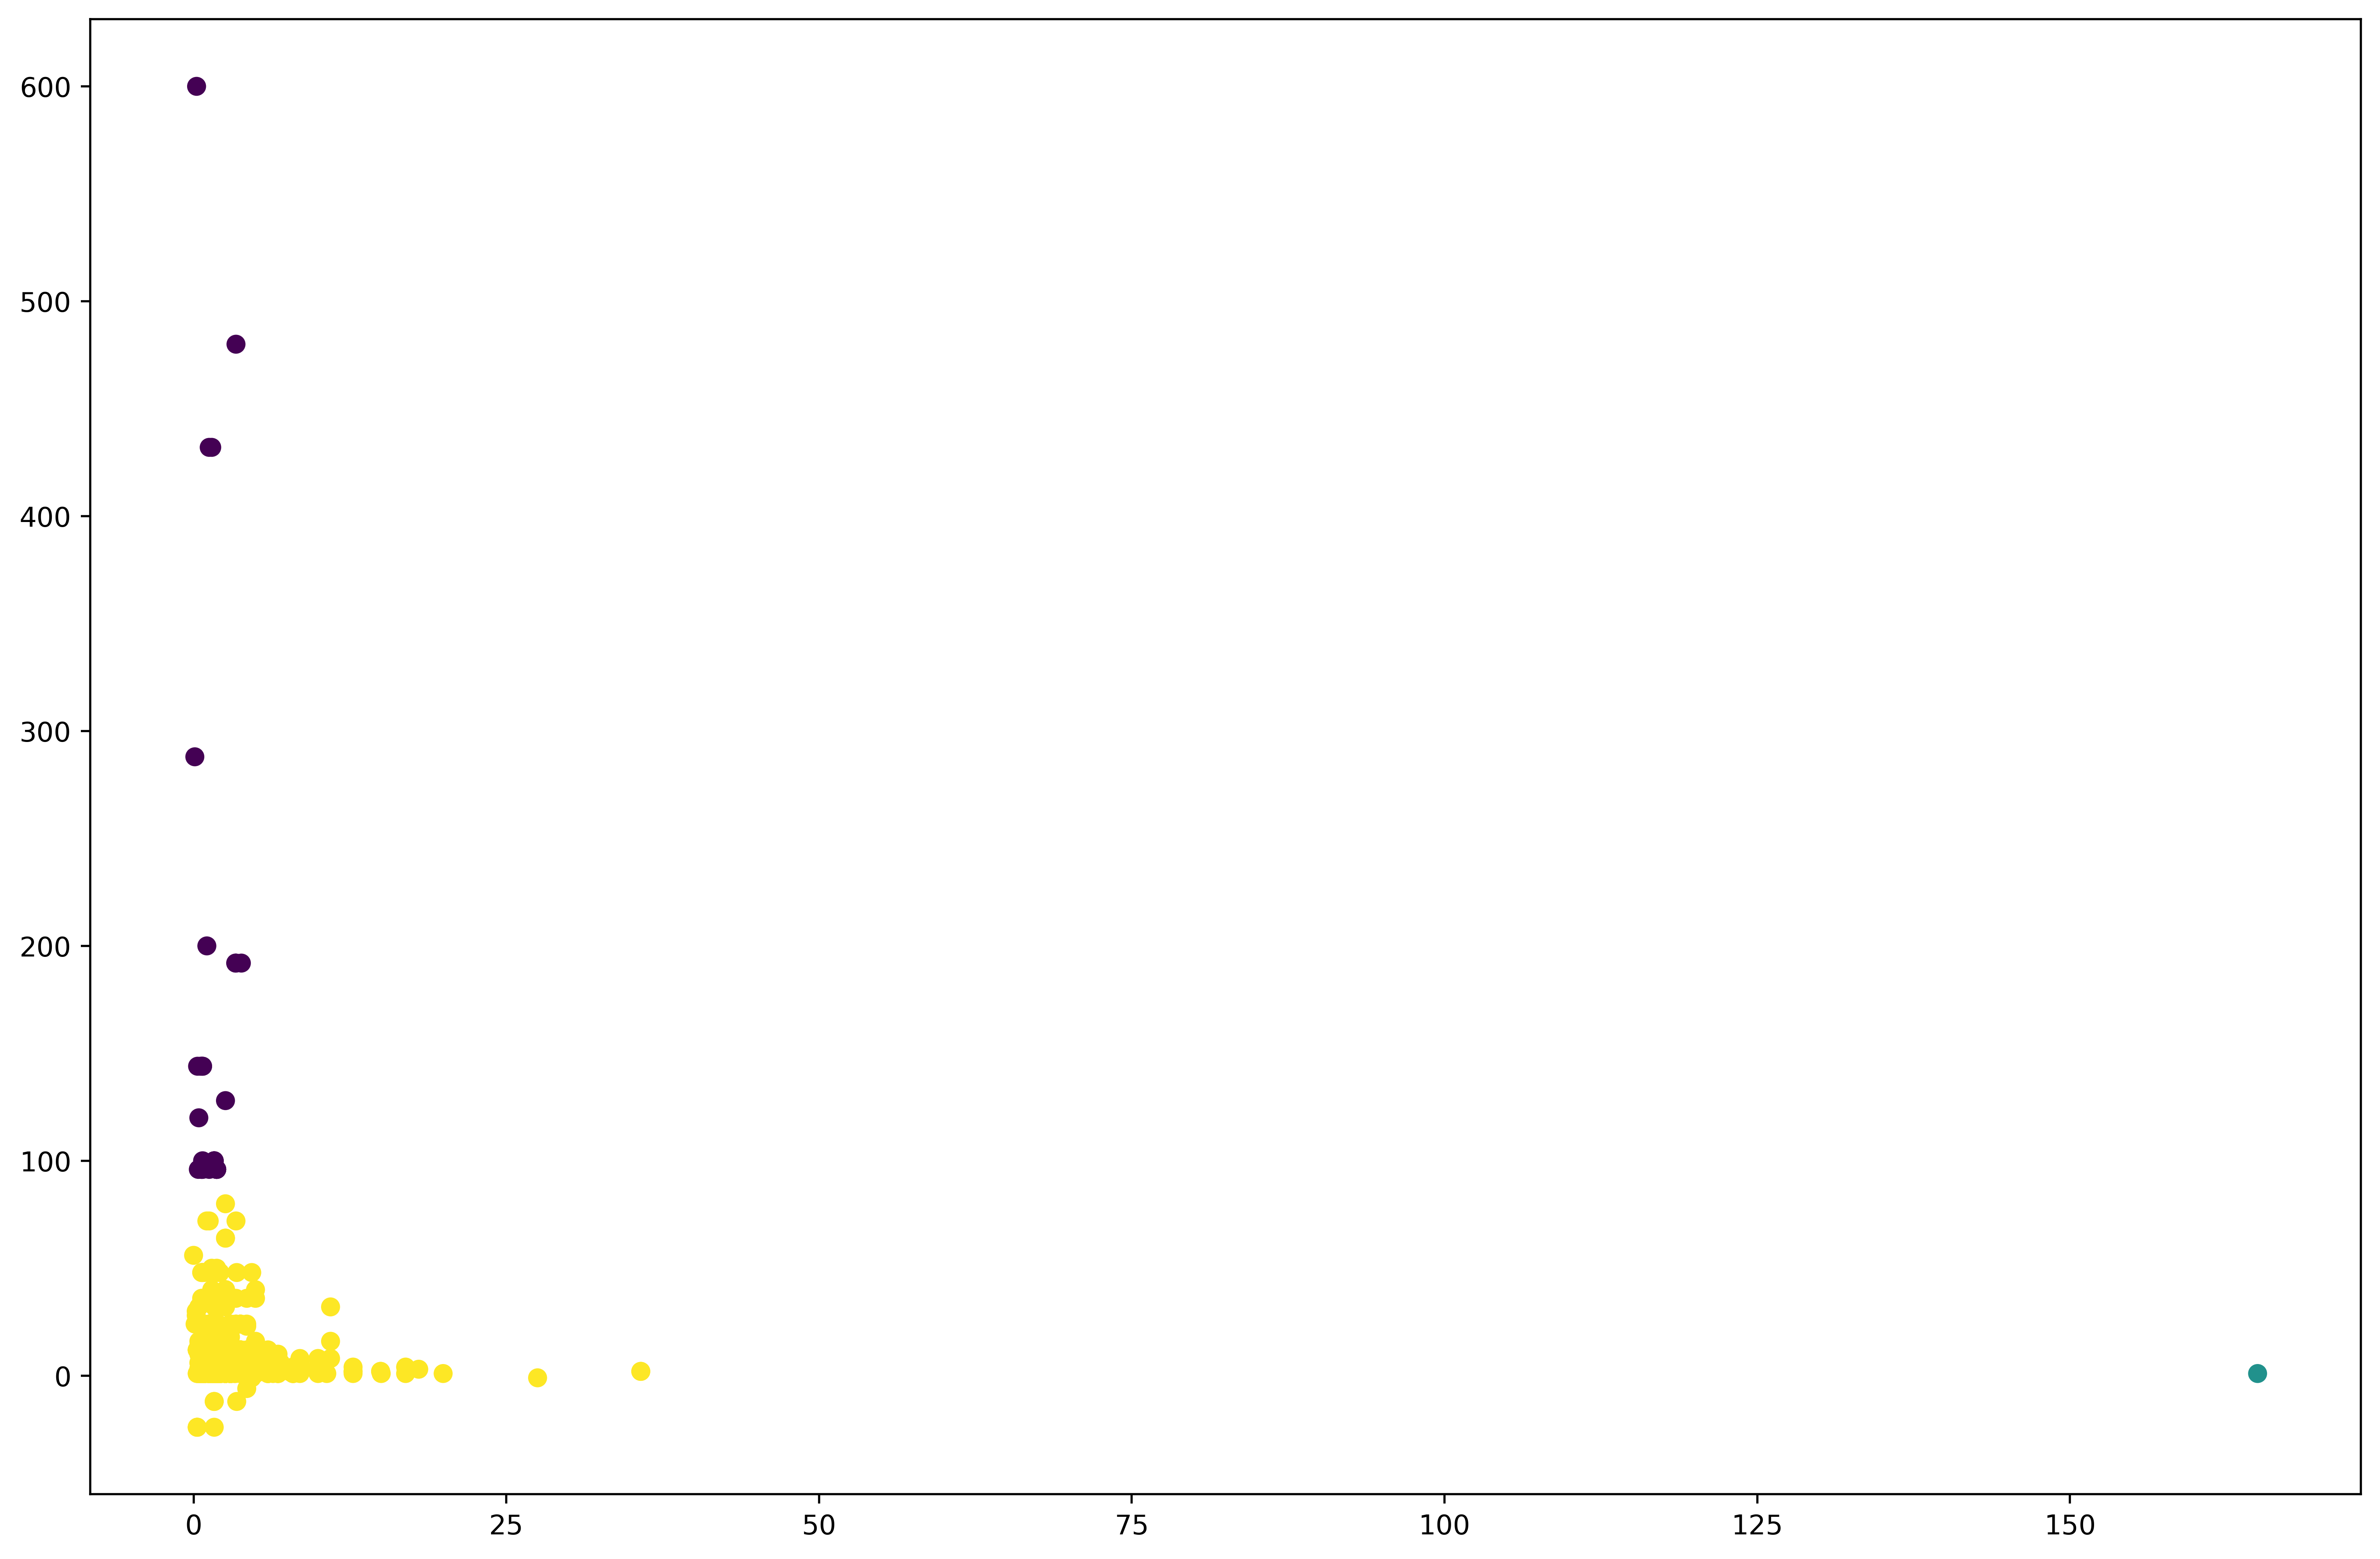

In [55]:
X = sc.inverse_transform(X)
plt.figure(figsize=(15,10), dpi=500)
plt.scatter(X[:,0], X[:,1], c=P)
plt.show()

## Elbow Method

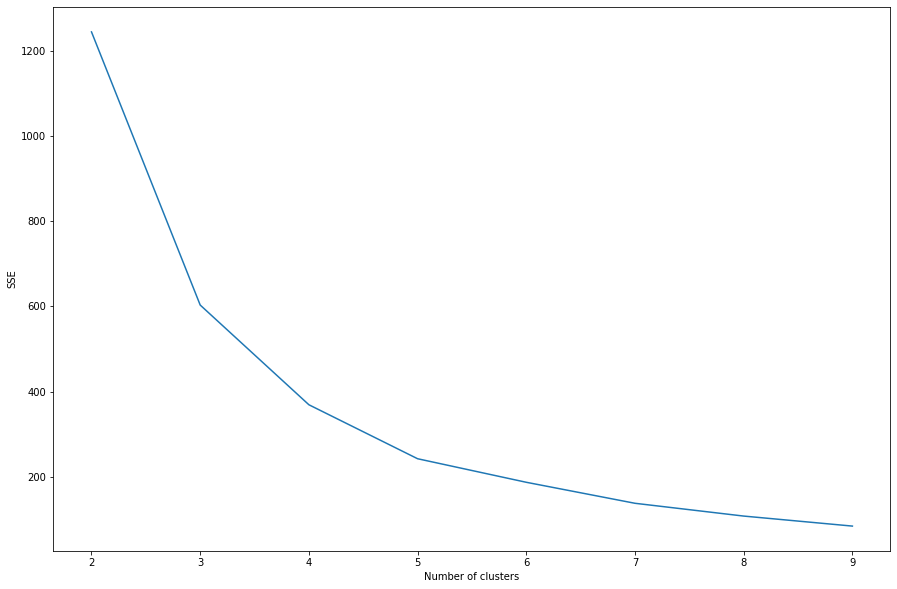

In [43]:
plt.figure(figsize=(15,10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

## Davies-Bouldin Index

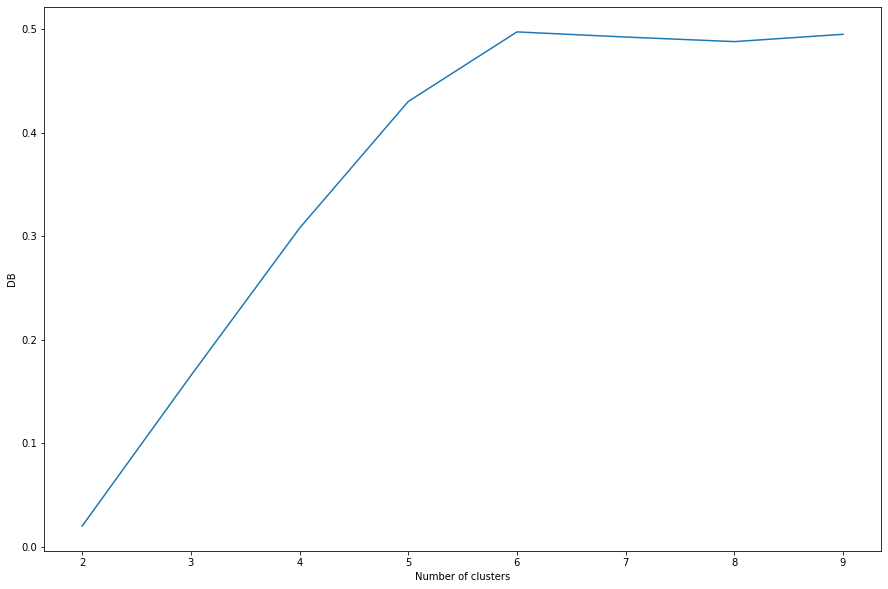

In [44]:
plt.figure(figsize=(15,10))
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel('Number of clusters')
plt.ylabel('DB')
plt.show()

In [45]:
print(list(db.keys())[list(db.values()).index(min(db.values()))])

2


## Silhouette Analysis

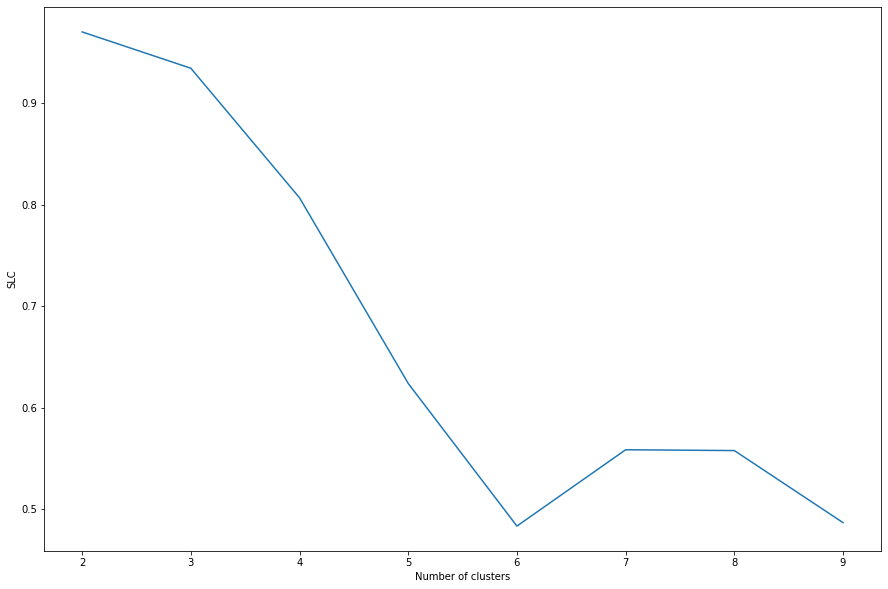

In [46]:
plt.figure(figsize=(15,10))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel('Number of clusters')
plt.ylabel('SLC')
plt.show()

In [47]:
print(list(slc.keys())[list(slc.values()).index(max(slc.values()))])

2


For n_clusters = 2 The average silhouette_score is : 0.9700502777625275


NameError: name 'cm' is not defined

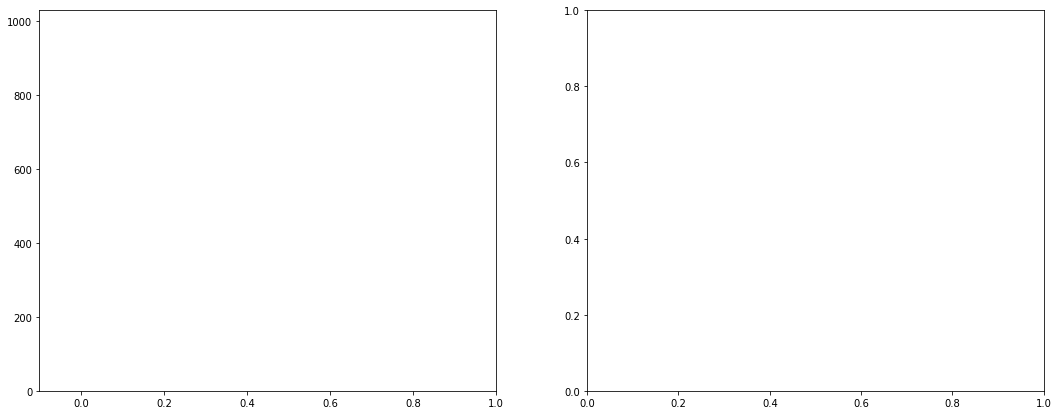

In [48]:
for n_clusters in range(2, 10):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,max_iter=1000, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()